In [14]:
"""Required imports"""
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pytz
import pandas_datareader.data as web

In [12]:
"""This cell defines the plot_candles function"""

def plot_candles(pricing, title=None,
                 volume_bars=False,
                 color_function=None,
                 overlays=None,
                 technicals=None,
                 technicals_titles=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      volume_bars: If True, plots volume bars
      color_function: A function which, given a row index and price series, returns a candle color.
      overlays: A list of additional data series to overlay on top of pricing.  Must be the same length as pricing.
      technicals: A list of additional data series to display as subplots.
      technicals_titles: A list of titles to display for each technical indicator.
    """
    def default_color(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    color_function = color_function or default_color
    overlays = overlays or []
    technicals = technicals or []
    technicals_titles = technicals_titles or []
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    subplot_count = 1
    if volume_bars:
        subplot_count = 2
    if technicals:
        subplot_count += len(technicals)
    
    if subplot_count == 1:
        fig, ax1 = plt.subplots(1, 1)
    else:
        ratios = np.insert(np.full(subplot_count - 1, 1), 0, 3)
        fig, subplots = plt.subplots(subplot_count, 1, sharex=True, gridspec_kw={'height_ratios': ratios})
        ax1 = subplots[0]
        
    if title:
        ax1.set_title(title)
    x = np.arange(len(pricing))
    candle_colors = [color_function(i, open_price, close_price, low, high) for i in x]
    candles = ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, linewidth=0)
    lines = ax1.vlines(x + 0.4, low, high, color=candle_colors, linewidth=1)
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%d-%m-%Y'
    if frequency == 'minute':
        time_format = '%H:%M'
    # Set X axis tick labels.
    plt.xticks(x, [date.strftime(time_format) for date in pricing.index], rotation='vertical')
    for overlay in overlays:
        ax1.plot(x, overlay)
    # Plot volume bars if needed
    if volume_bars:
        ax2 = subplots[1]
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
    # Plot additional technical indicators
    for (i, technical) in enumerate(technicals):
        ax = subplots[i - len(technicals)] # Technical indicator plots are shown last
        ax.plot(x, technical)
        if i < len(technicals_titles):
            ax.set_title(technicals_titles[i])

In [4]:
"""This cell defines the plot_candles function"""
def plot_candles(pricing, title=None,
                 timezone='US/Eastern',
                 max_x_ticks=15,
                 volume_bars=False,
                 color_function='redgreen',
                 overlays=None,
                 technicals=None,
                 technicals_titles=None):
    """ Plots a candlestick chart using quantopian pricing data.
    
    Author: Daniel Treiman
    
    Args:
      pricing: A pandas dataframe with columns ['open_price', 'close_price', 'high', 'low', 'volume']
      title: An optional title for the chart
      timezone: timezone to use for formatting intraday data.
      max_x_ticks: The maximum number of X ticks with labels, to keep the X axis readable. 
      volume_bars: If True, plots volume bars
      color_function: ('redgreen', 'hollow') or a function which, given a row index and price data, returns a candle color.
      overlays: A list of additional data series to overlay on top of pricing.  Must be the same length as pricing.
      technicals: A list of additional data series to display as subplots.
      technicals_titles: A list of titles to display for each technical indicator.
    """
    overlays = overlays or []
    technicals = technicals or []
    technicals_titles = technicals_titles or []
    
    # ---- Builtin color functions ---
    def color_function_red_green(index, open_price, close_price, low, high):
        return 'r' if open_price[index] > close_price[index] else 'g'
    def color_function_filled_hollow(index, open_price, close_price, low, high):
        return 'k' if open_price[index] > close_price[index] else 'w'
    if color_function == 'redgreen':
        color_function = color_function_red_green
    elif color_function == 'hollow':
        color_function = color_function_filled_hollow
        
    # ---- Get price of bar bottom and tops ----
    open_price = pricing['open_price']
    close_price = pricing['close_price']
    low = pricing['low']
    high = pricing['high']
    oc_min = pd.concat([open_price, close_price], axis=1).min(axis=1)
    oc_max = pd.concat([open_price, close_price], axis=1).max(axis=1)
    
    # ---- Set up plot layout ----
    subplot_count = 1
    if volume_bars:
        subplot_count = 2
    if technicals:
        subplot_count += len(technicals)
    if subplot_count == 1:
        fig, ax1 = plt.subplots(1, 1)
    else:
        ratios = np.insert(np.full(subplot_count - 1, 1), 0, 3)
        fig, subplots = plt.subplots(subplot_count, 1, sharex=True, gridspec_kw={'height_ratios': ratios})
        ax1 = subplots[0]
    if title:
        ax1.set_title(title)
        
    # ---- Plot bars and wicks ----
    x = np.arange(len(pricing))
    x_midline = x + 0.4  # Approximate left of the centerline of each bar
    bar_width = 0.8
    if len(x) > 100: # Hack: shrink bar width as we increase the number of bars to prevent edge overlap
        bar_width = 0.6
        x_midline = x + 0.3
    candle_colors = [color_function(i, open_price, close_price, low, high) or
                     color_function_filled_hollow(i, open_price, close_price, low, high) for i in x]
    edge_colors = ['k' if c == 'w' else c for c in candle_colors]
    ax1.bar(x, oc_max-oc_min, bottom=oc_min, color=candle_colors, edgecolor=edge_colors, width=bar_width, linewidth=1)
    ax1.vlines(x_midline, low, oc_min, color=edge_colors, linewidth=1) # low wick
    ax1.vlines(x_midline, oc_max, high, color=edge_colors, linewidth=1) # high wick
    
    # ---- Date and time formats ----
    # Assume minute frequency if first two bars are in the same day.
    frequency = 'minute' if (pricing.index[1] - pricing.index[0]).days == 0 else 'day'
    time_format = '%H:%M' if frequency == 'minute' else '%d-%m-%Y'
    
    # ---- Make X axis labels ---- 
    ax1.xaxis.grid(False)
    ax1.xaxis.set_tick_params(which='major', length=3.0, direction='in', top='off')
    labels_x = x_midline
    tz = pytz.timezone(timezone)
    labels = np.array([date.astimezone(tz).strftime(time_format) for date in pricing.index])
    # If we have more bars than max_x_ticks, limit the number of x axis labels to show
    if frequency == 'minute' and len(x) > max_x_ticks:
        if len(x) / 2 < max_x_ticks: # Label every other minute
            labels_x = labels_x[::2]
            labels = labels[::2]
        elif len(x) / 5 < max_x_ticks: # Label every 5 minutes
            labels_x = labels_x[::5]
            labels = labels[::5]
        elif len(x) / 15 < max_x_ticks: # Label every 15 minutes
            labels_x = labels_x[::15]
            labels = labels[::15]
    # TODO: label week start properly for holidays
    if frequency == 'day' and len(x) > max_x_ticks:
        if len(x) / 2 < max_x_ticks: # Label every other day
            labels_x = labels_x[::2]
            labels = labels[::2]
        elif len(x) / 5 < max_x_ticks: # Label every week
            mondays = np.where(pricing.index.dayofweek == 0)
            labels_x = labels_x[mondays]
            labels = labels[mondays]
        elif len(x) / 15 < max_x_ticks: # Label every 2 weeks
            mondays = np.where(pricing.index.dayofweek == 0)
            every_other_monday = mondays[0::2]
            labels_x = labels_x[every_other_monday]
            labels = labels[every_other_monday]
    plt.xticks(labels_x, labels, ha='center')        
    
    # ---- Plot all overlays ----
    for overlay in overlays:
        ax1.plot(x, overlay)
        
    # ---- Plot volume bars if requested ----
    if volume_bars:
        ax2 = subplots[1]
        volume = pricing['volume']
        volume_scale = None
        scaled_volume = volume
        if volume.max() > 1000000:
            volume_scale = 'M'
            scaled_volume = volume / 1000000
        elif volume.max() > 1000:
            volume_scale = 'K'
            scaled_volume = volume / 1000
        ax2.bar(x, scaled_volume, color=candle_colors, width=bar_width, linewidth=1)
        volume_title = 'Volume'
        if volume_scale:
            volume_title = 'Volume (%s)' % volume_scale
        ax2.set_title(volume_title)
        ax2.xaxis.grid(False)
        
    # ---- Plot additional technical indicators in subplots ----
    for (i, technical) in enumerate(technicals):
        ax = subplots[i - len(technicals)] # Technical indicator plots are shown last
        ax.plot(x, technical)
        if i < len(technicals_titles):
            ax.set_title(technicals_titles[i])

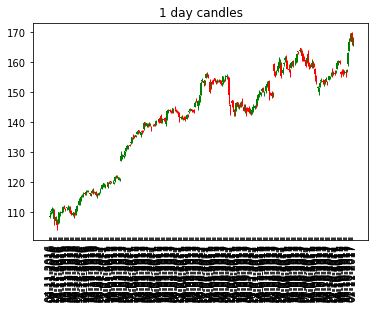

In [15]:
df = web.DataReader('aapl', 'google')
df.rename(columns={'Open': 'open_price', 'Close': 'close_price', 'Low':'low', 'High':'high'}, inplace=True)
plot_candles(df, title='1 day candles')


In [11]:
df.head()

,open_price,high,low,close_price,Volume
Date,,,,,
2016-11-04,108.53,110.25,108.11,108.84,30836997
2016-11-07,110.08,110.51,109.46,110.41,32560000
2016-11-08,110.31,111.72,109.70,111.06,24254179
2016-11-09,109.88,111.32,108.05,110.88,59176361
2016-11-10,111.09,111.09,105.83,107.79,57134541
